In [30]:
print('What\'s up?')

What's up?


# Notebook Imports

In [60]:
from os import walk
from os.path import join

import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image
import numpy as np

from sklearn.model_selection import train_test_split

%matplotlib inline

# Constants

In [32]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = 'SpamData/01_Processing/word-by-id.csv'

TRAINING_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'SpamData/02_Training/test-data.txt'

WHALE_FILE = 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'
THUMBS_UP_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
CUSTOM_FONT_FILE = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'

# Reading Files

In [33]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
message = stream.read()
stream.close()

print(type(message))
print(message)

<class 'str'>
From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: fro

In [34]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [35]:
stream = open(EXAMPLE_FILE, encoding='latin-1')

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True

stream.close()

email_body = '\n'.join(lines)
print(email_body)




Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Generator Functions

In [36]:
def generate_squares(N):
    for my_number in range(N):
        yield my_number ** 2

In [37]:
for i in generate_squares(5):
    print(i, end=' ->')

0 ->1 ->4 ->9 ->16 ->

## Email body extraction

In [38]:
def email_body_generator(path):
    
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            
            yield file_name, email_body


In [39]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [40]:
spam_emails = df_from_directory(SPAM_1_PATH, 1)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, 1))
spam_emails.head()

,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [41]:
type(spam_emails)

pandas.core.frame.DataFrame

In [42]:
spam_emails.shape

(1898, 2)

In [43]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))
ham_emails.shape

(3901, 2)

In [44]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of entire dataframe is ', data.shape)
data.head()

Shape of entire dataframe is  (5799, 2)


,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [45]:
data.tail()

,MESSAGE,CATEGORY
01396.61983fbe6ec43f55fd44e30fce24ffa6,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,"> >-- be careful when using this one.) Also, t...",0
01398.169b51731fe569f42169ae8f948ec676,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0
01400.f897f0931e461e7b2e964d28e927c35e,"Hi there,\n\n\n\nNow this is probably of no us...",0


# Data Cleaning: Checking for Missing Values

In [46]:
# check if any message bodies are null
data['MESSAGE'].isnull().values.any()

False

In [47]:
type("")

str

In [48]:
len("")

0

In [49]:
my_var = None

In [50]:
type(my_var)

NoneType

In [51]:
# check if there are empty emails (string length zero)
(data.MESSAGE.str.len() == 0).any()

True

In [52]:
(data.MESSAGE.str.len() == 0).sum()

3

In [53]:
# Challenge: how would you check the number of entries with null/None values?
data.MESSAGE.isnull().sum()

0

### Locate empty emails

In [54]:
type(data.MESSAGE.str.len() == 0)

pandas.core.series.Series

In [55]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [56]:
data.index.get_loc('.DS_Store')

KeyError: '.DS_Store'

In [ ]:
data[4608:4611]

# Remove System File Entries from Dataframe

In [ ]:
data.drop(['cmds', '.DS_Store'], inplace=True)

data[4608:4611]

In [ ]:
data.shape

# Add Document IDs to Track Emails in Dataset

In [ ]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids

In [ ]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)
data.head()

In [ ]:
data.tail()

# Save to File using Pandas

In [ ]:
data.to_json(DATA_JSON_FILE)

# Number of Spam Messages Visualised (Pie Charts)

In [57]:
data.CATEGORY.value_counts()

0    3901
1    1898
Name: CATEGORY, dtype: int64

In [ ]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

In [ ]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
       autopct='%1.0f%%')
plt.show()

In [ ]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ['#ff7675', '#74b9ff']

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
       autopct='%1.0f%%', colors=custom_colours, explode=[0, 0.1])
plt.show()

In [ ]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ['#ff7675', '#74b9ff']

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
       autopct='%1.0f%%', colors=custom_colours, pctdistance=0.8)

# draw circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

In [ ]:
category_names = ['Spam', 'Legit Mail', 'Updates', 'Promotions']
sizes = [25, 43, 19, 22]
custom_colours = ['#ff7675', '#74b9ff', '#55efc4', '#ffeaa7']
offset = [0.05, 0.05, 0.05, 0.05]

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
       autopct='%1.0f%%', colors=custom_colours, pctdistance=0.8, explode=offset)

# draw circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

# Natural Language Processing

### Text Pre-Processing

In [ ]:
# convert to lower case
msg = 'All work and no play makes Jack a dull boy.'
msg.lower()

### Download the NLTK Resources (Tokenizer & Stopwords)

In [ ]:
nltk.download('punkt')

In [ ]:
nltk.download('stopwords')

In [ ]:
nltk.download('gutenberg')
nltk.download('shakespeare')

## Tokenising

In [ ]:
msg = 'All work and no play makes Jack a dull boy.'
word_tokenize(msg.lower())

## Removing Stop Words 

In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
type(stop_words)

In [ ]:
if 'this' in stop_words: print('Found it!')

In [ ]:
# Challenge: print out 'Nope. Not in here' if the word "hello" is not contained in stop_words

In [ ]:
if 'hello' not in stop_words: print('Nope. Not in here')

In [ ]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be.'
words = word_tokenize(msg.lower())

filtered_words = []
# Challenge: append non-stop words to filtered_words
for word in words:
    if word not in stop_words:
        filtered_words.append(word)

print(filtered_words)

## Word Stems and Stemming

In [ ]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. \
      Nobody expects the Spanish Inquisition!'
words = word_tokenize(msg.lower())

# stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')


filtered_words = []
# Challenge: append non-stop words to filtered_words
for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

print(filtered_words)

## Removing Punctuation

In [ ]:
'p'.isalpha()

In [ ]:
'?'.isalpha()

In [ ]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. ??? \
      Nobody expects the Spanish Inquisition!'

words = word_tokenize(msg.lower())
stemmer = SnowballStemmer('english')
filtered_words = []

for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

print(filtered_words)

## Removing HTML tags from Emails

In [ ]:
soup = BeautifulSoup(data.at[2, 'MESSAGE'], 'html.parser')
print(soup.prettify())

In [ ]:
soup.get_text()

## Functions for Email Processing

In [ ]:
def clean_message(message, stemmer=PorterStemmer(), 
                 stop_words=set(stopwords.words('english'))):
    
    # Converts to Lower Case and splits up the words
    words = word_tokenize(message.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

In [ ]:
clean_message(email_body)

In [ ]:
# Challenge: Modify function to remove HTML tags. Then test on Email with DOC_ID 2. 
def clean_msg_no_html(message, stemmer=PorterStemmer(), 
                 stop_words=set(stopwords.words('english'))):
    
    # Remove HTML tags
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    
    # Converts to Lower Case and splits up the words
    words = word_tokenize(cleaned_text.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
#             filtered_words.append(word) 
    
    return filtered_words

In [ ]:
clean_msg_no_html(data.at[2, 'MESSAGE'])

# Apply Cleaning and Tokenisation to all messages

### Slicing Dataframes and Series & Creating Subsets

In [58]:
data.iat[2, 2]

IndexError: index 2 is out of bounds for axis 0 with size 2

In [ ]:
data.iloc[5:11]

In [ ]:
first_emails = data.MESSAGE.iloc[0:3]

nested_list = first_emails.apply(clean_message)

In [ ]:
# flat_list = []
# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)

flat_list = [item for sublist in nested_list for item in sublist]
        
len(flat_list)

In [ ]:
flat_list

In [ ]:
%%time

# use apply() on all the messages in the dataframe
nested_list = data.MESSAGE.apply(clean_msg_no_html)

In [ ]:
nested_list.tail()

### Using Logic to Slice Dataframes

In [ ]:
data[data.CATEGORY == 1].shape

In [ ]:
data[data.CATEGORY == 1].tail()

In [ ]:
# Challenge: create two variables (doc_ids_spam, doc_ids_ham) which 
# hold onto the indices for the spam and the non-spam emails respectively. 

In [ ]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

In [ ]:
doc_ids_ham

### Subsetting a Series with an Index

In [ ]:
type(doc_ids_ham)

In [ ]:
type(nested_list)

In [ ]:
nested_list_ham = nested_list.loc[doc_ids_ham]

In [ ]:
nested_list_ham.shape

In [ ]:
nested_list_ham.tail()

In [ ]:
nested_list_spam = nested_list.loc[doc_ids_spam]

In [ ]:
# Challenge: use python list comprehension and then find the total number of 
# words in our cleaned dataset of spam email bodies. Also find the total number of 
# words in normal emails in the dataset. Then find the 10 most common words used in 
# spam. Also, find the 10 most common words used in non-spam messages. 

In [ ]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()

normal_words.shape[0] # total number of unique words in the non-spam messages

In [ ]:
normal_words[:10]

In [ ]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()

spammy_words.shape[0] # total number of unique words in the spam messages

In [ ]:
spammy_words[:10]

# Creating a Word Cloud

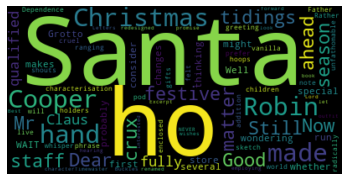

In [61]:
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')
len(example_corpus)

In [ ]:
type(example_corpus)

In [ ]:
example_corpus

In [ ]:
word_list = [''.join(word) for word in example_corpus]
novel_as_string = ' '.join(word_list)

In [ ]:
icon = Image.open(WHALE_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                      max_words=400, colormap='ocean')

word_cloud.generate(novel_as_string)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
rgb_array.shape

In [ ]:
rgb_array[1023, 2047]

In [ ]:
rgb_array[500, 1000]

In [ ]:
# Challenge: use the skull image in the lesson resources to create a word cloud
# for Shakespeare's play Hamlet

In [ ]:
hamlet_corpus = nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')
word_list = [''.join(word) for word in hamlet_corpus]
hamlet_as_string = ' '.join(word_list)

skull_icon = Image.open(SKULL_FILE)
image_mask = Image.new(mode='RGB', size=skull_icon.size, color=(255, 255, 255))
image_mask.paste(skull_icon, box=skull_icon)
rgb_array = np.array(image_mask)

word_cloud = WordCloud(mask=rgb_array, background_color='white',
                      colormap='bone', max_words=600)

word_cloud.generate(hamlet_as_string)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Word Cloud of Ham and Spam Messages

In [ ]:
icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

# Generate the text as a string for the word cloud
ham_str = ' '.join(flat_list_ham)

word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                      max_words=500, colormap='winter')

word_cloud.generate(ham_str)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# Challenge: Look at the word cloud documentation. Use the custom font included in the 
# lesson resources instead of the default font and create a word cloud of the spammy words

In [ ]:
icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

# Generate the text as a string for the word cloud
spam_str = ' '.join(flat_list_spam)

word_cloud = WordCloud(mask=rgb_array, background_color='white', max_font_size=300,
                      max_words=2000, colormap='gist_heat', font_path=CUSTOM_FONT_FILE)

word_cloud.generate(spam_str.upper())

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Generate Vocabulary & Dictionary

In [ ]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

In [ ]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('Nr of unique words', unique_words.shape[0])
unique_words.head()

In [ ]:
# Challenge: Create subset of the series called 'frequent_words' that only contains
# the most common 2,500 words out of the total. Print out the top 10 words

In [ ]:
frequent_words = unique_words[0:VOCAB_SIZE]
print('Most common words: \n', frequent_words[:10])

## Create Vocabulary DataFrame with a WORD_ID

In [ ]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

## Save the Vocabulary as a CSV File

In [ ]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

# Exercise: Checking if a Word is Part of the Vocabulary

In [ ]:
# Challenge: Write a line of code that checks if a particular word is part 
# of the vocabulary. Your code should return True if the word is among the 
# 2,500 words that comprise the vocabulary, and False otherwise. Check these words:
# 'machine'
# 'learning'
# 'fun'
# 'learn'
# 'data'
# 'science'
# 'app'
# 'brewery'

In [ ]:
any(vocab.VOCAB_WORD == 'machine') # inefficient

In [ ]:
'brew' in set(vocab.VOCAB_WORD) # better way

# Exercise: Find the Email with the Most Number of Words

In [ ]:
# Challenge: Print out the number of words in the longest email (after cleaning & stemming).
# Note the longest email's position in the list of cleaned emails. Print out the stemmed
# list of words in the longest email. Print out the longest email from the data dataframe.

# Hint: use the len() function and practice list comprehension

In [ ]:
# For loop
clean_email_lengths = []
for sublist in stemmed_nested_list:
    clean_email_lengths.append(len(sublist))

In [ ]:
# Python List Comprehension
clean_email_lengths = [len(sublist) for sublist in stemmed_nested_list]
print('Nr words in the longest email:', max(clean_email_lengths))


In [ ]:
print('Email position in the list (and the data dataframe)', np.argmax(clean_email_lengths))


In [ ]:
stemmed_nested_list[np.argmax(clean_email_lengths)]


In [ ]:
data.at[np.argmax(clean_email_lengths), 'MESSAGE']


# Generate Features & a Sparse Matrix

### Creating a DataFrame with one Word per Column

In [ ]:
type(stemmed_nested_list)

In [ ]:
type(stemmed_nested_list.tolist())

In [ ]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head()

In [ ]:
word_columns_df.shape

### Splitting the Data into a Training and Testing Dataset

In [ ]:
# Challenge: Can you split the data into a training and testing set? Set the test size at 30%. 
# The training data should include 4057 emails. Use a seed value of 42 to shuffle the data. 
# What should the target values be? 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY,
                                                   test_size=0.3, random_state=42)

In [ ]:
print('Nr of training samples', X_train.shape[0])
print('Fraction of training set', X_train.shape[0] / word_columns_df.shape[0])

In [ ]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

In [ ]:
y_train.head()


### Create a Sparse Matrix for the Training Data

In [ ]:
word_index = pd.Index(vocab.VOCAB_WORD)
type(word_index[3])

In [ ]:
word_index.get_loc('thu')

In [ ]:
def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns sparse matrix as dataframe.
    
    df: A dataframe with words in the columns with a document id as an index (X_train or X_test)
    indexed_words: index of words ordered by word id
    labels: category as a series (y_train or y_test)
    """
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word = df.iat[i, j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL': category, 'DOC_ID': doc_id,
                       'OCCURENCE': 1, 'WORD_ID': word_id}
                
                dict_list.append(item)
    
    return pd.DataFrame(dict_list)

In [ ]:
%%time
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

In [ ]:
sparse_train_df[:5]

In [ ]:
sparse_train_df.shape

In [ ]:
sparse_train_df[-5:]

### Combine Occurrences with the Pandas groupby() Method

In [ ]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped.head()

In [ ]:
vocab.at[0, 'VOCAB_WORD']

In [ ]:
data.MESSAGE[0]

In [ ]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

In [ ]:
train_grouped.tail()

In [ ]:
vocab.at[1923, 'VOCAB_WORD']

In [ ]:
data.MESSAGE[5795]

In [ ]:
train_grouped.shape

### Save Training Data as .txt File

In [ ]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

In [ ]:
train_grouped.columns

# Challenge

Can you create a sparse matrix for the test data. Group the occurrences of the same word in the same email. Then save the data as a .txt file. 

In [ ]:
X_test.head()

In [ ]:
y_test.head()

In [ ]:
X_test.shape

In [ ]:
%%time
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

In [ ]:
sparse_test_df.shape

In [ ]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum().reset_index()
test_grouped.head()

In [ ]:
test_grouped.shape

In [ ]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')

# Pre-Processing Subtleties and Checking your Understanding

Challenge: We started with 5796 emails. We split it into 4057 emails for training and 1739 emails for testing. 

How many individual emails were included in the testing .txt file? Count the number in the test_grouped DataFrame. After splitting and shuffling our data, how many emails were included in the X_test DataFrame? Is the number the same? If not, which emails were excluded and why? Compare the DOC_ID values to find out.

In [ ]:
train_doc_ids = set(train_grouped.DOC_ID)
test_doc_ids = set(test_grouped.DOC_ID)

In [ ]:
len(test_doc_ids)

In [ ]:
len(X_test)

In [ ]:
set(X_test.index.values) - test_doc_ids # Excluded emails after pre-processing

In [ ]:
data.MESSAGE[14]

In [ ]:
data.loc[14]

In [ ]:
clean_msg_no_html(data.at[14, 'MESSAGE'])

In [ ]:
data.MESSAGE[1096]

In [ ]:
clean_msg_no_html(data.at[1096, 'MESSAGE'])

In [ ]:
clean_message(data.at[1096, 'MESSAGE'])